In [1]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
import pickle
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("Langgraph")

LangSmith 추적을 시작합니다.
[프로젝트명]
Langgraph


In [3]:
with open("results/split_documents.pkl", "rb") as f:
    split_documents = pickle.load(f)

In [4]:
vectorstore = FAISS.load_local(
    "faiss_index", 
    OpenAIEmbeddings(),
    allow_dangerous_deserialization=True  # needed in newer versions
)

In [165]:
faiss_retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

In [166]:
bm25_retriever = BM25Retriever.from_documents(
    split_documents,
)
bm25_retriever.k = 1

In [167]:
ensemble_retriever = EnsembleRetriever(
    retrievers=[bm25_retriever, faiss_retriever],
    weights=[0.7, 0.3],
)

In [168]:
# 검색 결과 문서를 가져옵니다.
query = "what are risks and challenges of Korea in global economy?"
ensemble_result = ensemble_retriever.invoke(query)
bm25_result = bm25_retriever.invoke(query)
faiss_result = faiss_retriever.invoke(query)

# 가져온 문서를 출력합니다.
print("[Ensemble Retriever]")
for doc in ensemble_result:
    print(f"Content: {doc.page_content}")
    print()

print("[BM25 Retriever]")
for doc in bm25_result:
    print(f"Content: {doc.page_content}")
    print()

print("[FAISS Retriever]")
for doc in faiss_result:
    print(f"Content: {doc.page_content}")
    print()

[Ensemble Retriever]
Content: 27. Stretched valuations in financial markets, including the rapid growth in crypto-asset market  
capitalisation, and the growing interconnections between banks and non-bank financial institutions call for  
enhanced vigilance to safeguard financial stability. Effective monitoring, supervision and robust regulatory  
policies are needed, particularly of potential liquidity mismatches and leverage risks for non-bank financial  
institutions, in line with internationally-recommended norms. Enhancing reporting requirements and filling  
data gaps would improve the monitoring of risks and help relevant authorities mitigate financial  
vulnerabilities and prepare for possible future corrections in asset prices that would have systemic  
consequences. While crypto-assets share some characteristics with traditional financial products, they  
present a unique set of policy challenges given their borderless and pseudonymous nature. Countries

Content: 32. Recent e

In [169]:
ensemble_result

[Document(metadata={'page': 21, 'image_id': [168], 'image_path': ['images/sample_cropped_chart_168.png'], 'text_summary': [], 'image_summary': 'Here’s a description of the figure shown in the image:\n\n- Title: Figure 10. Policy rates are expected to ease gradually\n- Layout: Two panels (A and B) showing policy interest rates over time (2022 to 2026) with percentage on the y-axis.\n\nPanel A – Advanced economy policy interest rates\n- Countries in the legend: United States (red), Euro area (blue), Japan (green), United Kingdom (orange).\n- This panel plots the midpoint of policy rates for the US (Fed funds rate) and the euro area (ECB deposit facility rate).\n- Trends (roughly):\n  - United States (red): rises to around 5% by 2023, then gradually eases to roughly 3–4% by 2026.\n  - Euro area (blue): climbs to about 3–4% around 2023–2024, then eases toward about 2% by 2026.\n  - United Kingdom (orange): similar to the US, rising to around 5% in the early-to-mid 2020s and easing to rough

In [189]:
from langchain.schema import Document
def format_context(results: list[Document]) -> str:
    arr = []
    for i, doc in enumerate(results):
        text = f"""Retrieved #{i+1}
                    {doc.page_content}
                    {doc.metadata['text_summary'] if len(doc.metadata['text_summary']) > 0 else ''}
                    {doc.metadata['image_summary'] if len(doc.metadata['image_summary']) > 0 else ''}
                """
        arr.append(text)
    return "\n".join(arr)

In [190]:
format_context(ensemble_result)

'Retrieved #1\n                    27. Stretched valuations in financial markets, including the rapid growth in crypto-asset market  \ncapitalisation, and the growing interconnections between banks and non-bank financial institutions call for  \nenhanced vigilance to safeguard financial stability. Effective monitoring, supervision and robust regulatory  \npolicies are needed, particularly of potential liquidity mismatches and leverage risks for non-bank financial  \ninstitutions, in line with internationally-recommended norms. Enhancing reporting requirements and filling  \ndata gaps would improve the monitoring of risks and help relevant authorities mitigate financial  \nvulnerabilities and prepare for possible future corrections in asset prices that would have systemic  \nconsequences. While crypto-assets share some characteristics with traditional financial products, they  \npresent a unique set of policy challenges given their borderless and pseudonymous nature. Countries\n        

In [191]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)

In [192]:
# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = ensemble_retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    context = format_context(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return {"context": context}


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]
   
    llm = ChatOpenAI(model_name="gpt-5-mini", temperature=0)
      
    system_prompt = """You are an assistant for question-answering tasks. 
        Use the following pieces of retrieved context to answer the question. 
        If you don't know the answer, just say that you don't know. 
        Answer in Korean.
    """
    
    prompt = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": "Context: " + context},
        {"role": "user", "content": "Question: " + latest_question},
    ]
        
    # 체인을 호출하여 답변을 생성합니다.
    response = llm.invoke(prompt)
    print("response", response)
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return {
        "answer": response.content,
        "messages": [("user", latest_question), ("assistant", response.content)],
    }

In [193]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("llm_answer", llm_answer)

# 엣지 정의
workflow.add_edge("retrieve", "llm_answer")  # 검색 -> 답변
workflow.add_edge("llm_answer", END)  # 답변 -> 종료

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)

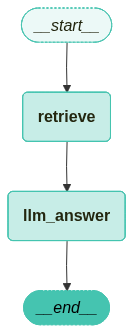

In [194]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)

In [198]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid
inputs = GraphState(question="한국이 직면한 위기와 도전을 알려주세요.")
# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": 1})

In [199]:
result = app.invoke(inputs, config=config)


response content='요약하면, 제공된 자료(2025년 중간 경제전망)에 따라 한국이 직면한 주요 위기와 도전은 다음과 같습니다.\n\n- 글로벌 교역·정책 불확실성\n  - 세계무역 체계의 투명성·예측 가능성 부족과 보호무역·정책 불협화음은 수출 중심의 한국에 큰 충격을 줄 수 있음. 국가 간 협력과 외교적·무역적 참여 강화가 필요함.\n\n- 물가·통화정책 위험\n  - 기저 인플레이션이 완화될 경우 금리 인하 여지가 있으나, 인플레이션 기대가 흔들리면 중앙은행은 계속 경계해야 함. 금리·물가 충격이 경기·금융시장에 파급될 위험이 있음.\n\n- 재정 지속가능성\n  - 장기적 재정 건전성 유지가 필요하며, 재정 여력이 약화되면 향후 충격 대응능력이 떨어질 수 있음. 재정 규율 유지가 과제임.\n\n- 구조개혁과 기술 전환\n  - 인공지능 등 신기술의 잠재력을 실물 성장·생산성 개선으로 연결하려면 노동시장·교육·산업 측면의 강화된 구조개혁이 필요함. 이를 못하면 생활수준 개선이 지체될 수 있음.\n\n- 금융안정 리스크 (자산가격·비은행권·암호자산)\n  - 자산(특히 기술주) 과대평가로 인한 리스크 재평가 시 급격한 변동·연쇄매도 가능성.\n  - 비은행 금융중개기관(NBFI)의 급성장과 은행 의존성은 시스템 리스크를 키울 수 있음.\n  - 암호자산 시장(2025년 기준 약 3.9조 달러 규모)은 변동성이 크고 스테이블코인 등에서 달러화·유동성 관련 위험(런)이 발생할 수 있어 규제·감시가 중요함.\n  - 미국·EU 등 주요국의 정책·규제 변화가 한국 금융시장·금융상품에 파급될 수 있음.\n\n- 외부 충격에 대한 취약성\n  - 예상보다 성장 둔화나 인플레이션 상승 등의 외부 충격이 발생하면 자산가격 재조정과 경기 변동성이 증대될 가능성이 있음.\n\n정책적 시사점(문서에서 제시된 대응 방향)\n- 국제무역 협력 강화와 무역정책의 투명성 제고\n- 중앙은행의 경계 유지(인플레이션 기대 관찰), 상황에 따라 금리 완화 가능\n- 재정 규율

In [204]:
result['answer']

'요약하면, 제공된 자료(2025년 중간 경제전망)에 따라 한국이 직면한 주요 위기와 도전은 다음과 같습니다.\n\n- 글로벌 교역·정책 불확실성\n  - 세계무역 체계의 투명성·예측 가능성 부족과 보호무역·정책 불협화음은 수출 중심의 한국에 큰 충격을 줄 수 있음. 국가 간 협력과 외교적·무역적 참여 강화가 필요함.\n\n- 물가·통화정책 위험\n  - 기저 인플레이션이 완화될 경우 금리 인하 여지가 있으나, 인플레이션 기대가 흔들리면 중앙은행은 계속 경계해야 함. 금리·물가 충격이 경기·금융시장에 파급될 위험이 있음.\n\n- 재정 지속가능성\n  - 장기적 재정 건전성 유지가 필요하며, 재정 여력이 약화되면 향후 충격 대응능력이 떨어질 수 있음. 재정 규율 유지가 과제임.\n\n- 구조개혁과 기술 전환\n  - 인공지능 등 신기술의 잠재력을 실물 성장·생산성 개선으로 연결하려면 노동시장·교육·산업 측면의 강화된 구조개혁이 필요함. 이를 못하면 생활수준 개선이 지체될 수 있음.\n\n- 금융안정 리스크 (자산가격·비은행권·암호자산)\n  - 자산(특히 기술주) 과대평가로 인한 리스크 재평가 시 급격한 변동·연쇄매도 가능성.\n  - 비은행 금융중개기관(NBFI)의 급성장과 은행 의존성은 시스템 리스크를 키울 수 있음.\n  - 암호자산 시장(2025년 기준 약 3.9조 달러 규모)은 변동성이 크고 스테이블코인 등에서 달러화·유동성 관련 위험(런)이 발생할 수 있어 규제·감시가 중요함.\n  - 미국·EU 등 주요국의 정책·규제 변화가 한국 금융시장·금융상품에 파급될 수 있음.\n\n- 외부 충격에 대한 취약성\n  - 예상보다 성장 둔화나 인플레이션 상승 등의 외부 충격이 발생하면 자산가격 재조정과 경기 변동성이 증대될 가능성이 있음.\n\n정책적 시사점(문서에서 제시된 대응 방향)\n- 국제무역 협력 강화와 무역정책의 투명성 제고\n- 중앙은행의 경계 유지(인플레이션 기대 관찰), 상황에 따라 금리 완화 가능\n- 재정 규율로 장기 채무 지속가능성 확보\

In [205]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="터키가 직면한 위기와 도전을 알려주세요.")

# 그래프 실행
invoke_graph(app, inputs, config)


🔄 Node: retrieve 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
context:
Retrieved #1
                    The Interim Report says that countries need to find ways of engaging co‑operatively within the global trading system  
and working together to make trade policy more transparent and predictable. Central banks should remain vigilant, but  
can lower policy interest rates where underlying inflation is projected to moderate towards target, provided inflation  
expectations remain well anchored. Fiscal discipline is needed to safeguard longer‑term debt sustainability and allow  
governments to react to future shocks. Enhanced structural reform efforts are required to durably improve living  
standards and help realise the potential from new technologies, such as artificial intelligence.

  

The Interim Report is an update on the assessment in the June 2025 of the Economic Outlook (Volume 2025 Issue 1).

PDF ISBN 978-92-64-57606-3

  

9HSTCQE\*fhgagd+
                    
     

In [207]:
for event in app.stream(inputs, config=config, stream_mode="updates"):
    for value in event.values():
        print(value)

{'context': 'Retrieved #1\n                    The Interim Report says that countries need to find ways of engaging co‑operatively within the global trading system  \nand working together to make trade policy more transparent and predictable. Central banks should remain vigilant, but  \ncan lower policy interest rates where underlying inflation is projected to moderate towards target, provided inflation  \nexpectations remain well anchored. Fiscal discipline is needed to safeguard longer‑term debt sustainability and allow  \ngovernments to react to future shocks. Enhanced structural reform efforts are required to durably improve living  \nstandards and help realise the potential from new technologies, such as artificial intelligence.\n\n  \n\nThe Interim Report is an update on the assessment in the June 2025 of the Economic Outlook (Volume 2025 Issue 1).\n\nPDF ISBN 978-92-64-57606-3\n\n  \n\n9HSTCQE\\*fhgagd+\n                    \n                    \n                \nRetrieved #2\